# 🌍 ERA5 Climate Data Processing Pipeline

---

## 📁 Read ERA5 Data at 0.5° Resolution
*Loading monthly SSRD and VPD data for 1980-1981 period*

> **Data Sources:**
> - SSRD (Surface Solar Radiation Downwards)
> - VPD (Vapor Pressure Deficit)
> - Resolution: 0.5° monthly
> - Time period: 2001-2020

In [8]:
import xarray as xr
from pathlib import Path
start_year = 2001
end_year = 2020

root = Path("/Net/Groups/data_BGC/era5/e1/0d50_monthly")
ssrd_paths = sorted(
    (root / f"ssrd/ssrd.monthly.fc.era5.720.360.{year}.nc")
    for year in range(start_year, end_year + 1)
)
vpd_paths = sorted(
    (root / f"vpd_cf/vpd_cf.monthly.calc.era5.720.360.{year}.nc")
    for year in range(start_year, end_year + 1)
)
# Read and merge SSRD files
ssrd_datasets = []
for path in ssrd_paths:
    ds = xr.open_dataset(path,engine='netcdf4')
    ssrd_datasets.append(ds)

ssrd_merged = xr.concat(ssrd_datasets, dim='time')

# Read and merge VPD files
vpd_datasets = []
for path in vpd_paths:
    ds = xr.open_dataset(path,engine='netcdf4')
    vpd_datasets.append(ds)

vpd_merged = xr.concat(vpd_datasets, dim='time')

# Alternative: More concise approach using list comprehension
ssrd_merged = xr.concat([xr.open_dataset(path) for path in ssrd_paths], dim='time')
vpd_merged = xr.concat([xr.open_dataset(path) for path in vpd_paths], dim='time')

# Optional: Combine both datasets into a single dataset
combined_dataset = xr.merge([ssrd_merged, vpd_merged])

print(f"SSRD dataset shape: {ssrd_merged.dims}")
print(f"VPD dataset shape: {vpd_merged.dims}")
print(f"Combined dataset variables: {list(combined_dataset.data_vars)}")

SSRD dataset shape: FrozenMappingWarningOnValuesAccess({'time': 240, 'latitude': 360, 'longitude': 720})
VPD dataset shape: FrozenMappingWarningOnValuesAccess({'time': 240, 'latitude': 360, 'longitude': 720})
Combined dataset variables: ['ssrd', 'vpd_cf']


---

## 🌊 Land Mask Application  
*Filter for terrestrial pixels only (excluding oceans and Antarctica)*

> **Filtering Criteria:**
> - ✅ Land pixels only (using Natural Earth coastlines)
> - ✅ Latitude > -60° (excludes Antarctica)
> - ❌ Ocean pixels removed
> - ❌ Antarctic regions removed

**Method:** Vectorized geometric contains operation for efficient masking

In [9]:
import numpy as np
import geopandas as gpd
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point
from shapely.vectorized import contains

# Get the land polygons from Natural Earth
land_shp = shpreader.natural_earth(resolution='110m', category='physical', name='land')
land_gdf = gpd.read_file(land_shp)
land_polygon = land_gdf.unary_union

def create_land_mask(ds, lat_threshold=-60):
    """Create a boolean mask where True = land, False = ocean"""
    # Extract the coordinate arrays
    lons = ds.longitude.values
    lats = ds.latitude.values

    # Create a meshgrid of coordinates (shape: [nlat, nlon])
    lon2d, lat2d = np.meshgrid(lons, lats)
    
    # Use vectorized contains to determine land pixels
    land_mask = contains(land_polygon, lon2d, lat2d)

    # Apply latitude threshold
    lat_mask = lat2d > lat_threshold

    return land_mask & lat_mask

# Create the land mask for your dataset
land_mask = create_land_mask(combined_dataset)

# Apply the mask to filter out ocean data (keep only land)
# Method 1: Using where() to set ocean values to NaN
land_only_dataset = combined_dataset.where(land_mask)

/tmp/ipykernel_1873896/2241829153.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  land_polygon = land_gdf.unary_union
/tmp/ipykernel_1873896/2241829153.py:22: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  land_mask = contains(land_polygon, lon2d, lat2d)


---

## ⚙️ Unit Conversion & Variable Renaming
*Standardize units and variable names for downstream processing*

### 📊 Unit Conversions Applied:
- **SSRD:** MJ/m²/day → W/m² 
  - Conversion factor: 1×10⁶ ÷ 86,400 = 11.574 W/m² per MJ/m²/day
  
### 🏷️ Variable Renaming:
- **vpd_cf** → **vpd** (simplified naming)

**Output:** Land-only dataset with standardized units saved as Zarr format

In [10]:
data = land_only_dataset
# Convert SSRD from MJ/m²/day to W/m²
# 1 MJ = 10^6 J
# 1 day = 24 * 3600 = 86400 seconds
# So: MJ/m²/day * 10^6 / 86400 = W/m²

conversion_factor = 1e6 / 86400  # ≈ 11.574 W/m² per MJ/m²/day

# Create a copy of the dataset and convert SSRD units
data['ssrd'] = data['ssrd'] * conversion_factor

# Update the attributes to reflect the new units
data['ssrd'].attrs['units'] = 'W m-2'
data['ssrd'].attrs['long_name'] = 'Surface solar radiation downwards'
data = data.rename({'vpd_cf': 'vpd'})

print(f"Original SSRD range: {np.nanmin(data['ssrd'].values):.2f} to {np.nanmax(data['ssrd'].values):.2f} MJ/m²/day")
print(f"Converted SSRD range: {np.nanmin(data['ssrd'].values):.2f} to {np.nanmax(data['ssrd'].values):.2f} W/m²")
print(f"Conversion factor used: {conversion_factor:.6f}")
data.to_zarr('data/era5_ssrd_vpd_2001-2020.zarr', mode='w')

Original SSRD range: -0.00 to 429.68 MJ/m²/day
Converted SSRD range: -0.00 to 429.68 W/m²
Conversion factor used: 11.574074


---

## 🧮 Create GPP and SIF - Meteorological Extrapolation
*Generate vegetation productivity estimates using meteorological models*

> **🎯 Objective:** Predict Gross Primary Productivity (GPP) and Solar-Induced Fluorescence (SIF) based on meteorological conditions
> 
> **📊 Input Variables:** SSRD, VPD
> 
> **🔬 Model Features:**
> - Meteorological-based extrapolation
> - Uncertainty quantification included
> - Spatial coverage: Global land areas (excluding Antarctica)

**Output:** Enhanced dataset with modeled GPP and SIF values

In [ ]:
import xarray as xr
data = xr.open_zarr('data/era5_ssrd_vpd_2001-2020.zarr')

In [11]:
import utils

data_meteo_ex = utils.SIF_GPP_model(data)
data_meteo_ex = utils.SIF_GPP_model_uncertainty(data_meteo_ex)

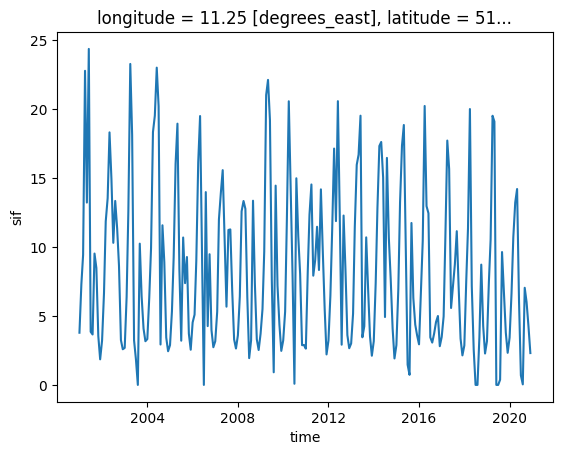

In [12]:
data_meteo_ex['sif'].sel(latitude=51.25,longitude=11.25).plot()

In [13]:
data_meteo_ex.to_zarr('data/era5_ssrd_vpd_2001-2020_meteo_ex.zarr', mode='w')

---

## 🌿 Create GPP and SIF - PFT Extrapolation
*Generate vegetation productivity estimates using Plant Functional Type models*

> **🎯 Objective:** Alternative GPP and SIF prediction using PFT-specific parameterization
> 
> **🌱 Model Approach:** 
> - Plant Functional Type (PFT) based extrapolation
> - SSRD factor integration (`use_f_ssrd=True`)
> - Uncertainty estimation for model predictions
> 
> **📈 Enhanced Features:**
> - Vegetation type-specific responses
> - Solar radiation factor weighting
> - Comprehensive uncertainty bounds

**Output:** PFT-based dataset with alternative GPP and SIF estimates

---

## 💾 Final Outputs
Both scenarios saved as compressed Zarr format for efficient data access and analysis.

In [14]:
data_pft_ex = utils.SIF_GPP_model_ssrd(data,use_f_ssrd=True)
data_pft_ex = utils.SIF_GPP_model_ssrd_uncertainty(data_pft_ex)
data_pft_ex

/Net/Groups/BGI/scratch/xyu/Ellis_challenge/utils.py:52: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds["latitude_var"] = ds["latitude"].expand_dims(dim={"time": ds.dims["time"], "longitude": ds.dims["longitude"]}).transpose("time", "latitude", "longitude")


<xarray.Dataset> Size: 3GB
Dimensions:         (time: 240, latitude: 360, longitude: 720)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2001-01-01T00:00:00.000040 ... ...
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * latitude        (latitude) float32 1kB 89.75 89.25 88.75 ... -89.25 -89.75
Data variables:
    ssrd            (time, latitude, longitude) float32 249MB nan nan ... nan
    vpd             (time, latitude, longitude) float32 249MB nan nan ... nan
    vpd_factor_gpp  (time, latitude, longitude) float64 498MB 0.0 0.0 ... 0.0
    vpd_factor_sif  (time, latitude, longitude) float64 498MB 0.0 0.0 ... 0.0
    gpp             (time, latitude, longitude) float64 498MB nan nan ... nan
    sif             (time, latitude, longitude) float64 498MB nan nan ... nan
    pft             (time, latitude, longitude) int64 498MB 3 3 3 3 ... 3 3 3 3
    ssrd_factor     (time, latitude, longitude) float64 498MB nan nan ... nan
Attributes:
    title:        era5 ssrd aggregated monthly
    version:      e1
    reference:    see:  http://apps.ecmwf.int/datasets/licences/copernicus/
    history:      created: Thu Nov 28 15:40:51 2019
    provided_by:  ECMWF/era5
    created_by:   uweber@bgc-jena.mpg.de

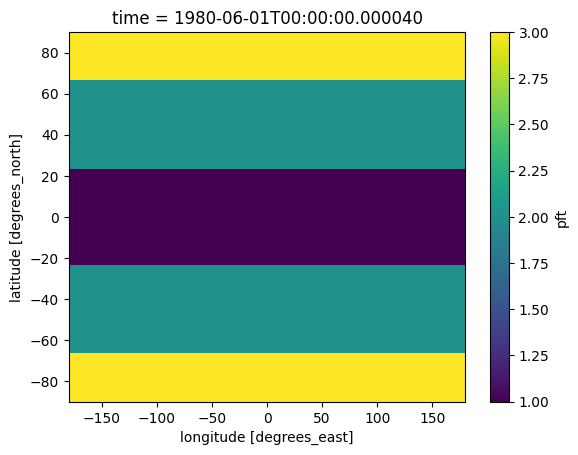

In [ ]:
data_pft_ex['pft'].isel(time=5).plot()

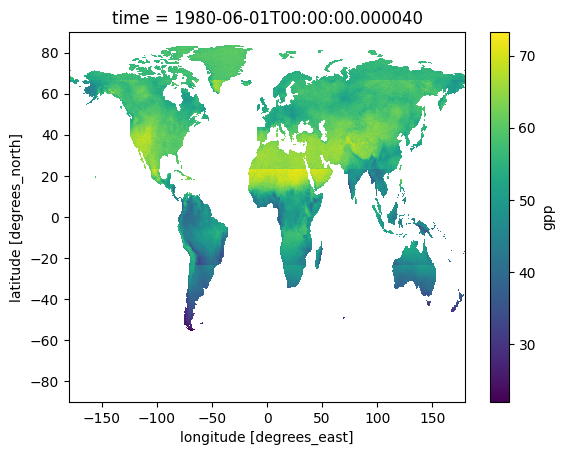

In [ ]:
data_pft_ex['gpp'].isel(time=5).plot()

In [15]:
data_pft_ex.to_zarr('data/era5_ssrd_vpd_2001-2020_pft_ex.zarr', mode='w')

---

## 🌡️ Climate-Constrained Sampling
*Extract 300 samples from regions with moderate vapor pressure deficit conditions*

> **Sampling Criteria:**
> - ✅ Mean VPD range: 5-10 kPa (moderate water stress conditions)
> - ✅ Land pixels only (using previous land mask)
> - ✅ Random sampling for representative coverage
> - ❌ Ocean pixels excluded
> - ❌ Extreme VPD regions excluded

**Purpose:** Create extrapolation issue due to unseen meteorological condition

**Output:** Specialized dataset with 300 representative samples (240 monthly timesteps) saved as compressed numpy arrays

In [16]:
# Randomly extract 300 samples with mean VPD between 5-10
import numpy as np

data_meteo_ex = xr.open_zarr('data/era5_ssrd_vpd_2001-2020_meteo_ex.zarr')

# Calculate mean VPD over time for each spatial point
mean_vpd = data_meteo_ex['vpd'].mean(dim='time')

# Create mask for VPD range (5-10)
vpd_mask = (mean_vpd >= 5) & (mean_vpd <= 10)

# Stack spatial dimensions and apply mask
stacked_data = data_meteo_ex.stack(points=('latitude', 'longitude'))
valid_points = stacked_data.where(vpd_mask.stack(points=('latitude', 'longitude')), drop=True)

# Get the number of valid points
n_valid = valid_points.points.size
print(f"Number of valid points (mean VPD 5-10): {n_valid}")

# Randomly sample 300 points
if n_valid >= 300:
    # Set random seed for reproducibility
    np.random.seed(42)
    random_indices = np.random.choice(n_valid, size=300, replace=False)
    sampled_data = valid_points.isel(points=random_indices)
    print(f"Successfully sampled 300 points")
else:
    print(f"Warning: Only {n_valid} valid points available, sampling all of them")
    sampled_data = valid_points

# Display sample statistics
print(f"\nSample VPD statistics:")
print(f"Min VPD: {sampled_data['vpd'].mean(dim='time').min().values:.2f}")
print(f"Max VPD: {sampled_data['vpd'].mean(dim='time').max().values:.2f}")
print(f"Mean VPD: {sampled_data['vpd'].mean(dim='time').mean().values:.2f}")

sampled_data

Number of valid points (mean VPD 5-10): 14182
Successfully sampled 300 points

Sample VPD statistics:
Min VPD: 5.08
Max VPD: 9.96
Mean VPD: 7.41


<xarray.Dataset> Size: 3MB
Dimensions:         (time: 240, points: 300)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2001-01-01T00:00:00.000040 ... ...
  * points          (points) object 2kB MultiIndex
  * latitude        (points) float64 2kB 35.25 33.75 -14.75 ... 31.75 30.25
  * longitude       (points) float64 2kB 68.25 -81.75 -64.25 ... -92.75 113.8
Data variables:
    gpp             (time, points) float64 576kB 150.2 112.9 ... 92.26 122.4
    sif             (time, points) float64 576kB 15.81 12.13 ... 9.909 10.33
    ssrd            (time, points) float32 288kB 151.5 122.3 ... 108.6 103.8
    vpd             (time, points) float32 288kB 1.848 3.554 ... 3.693 3.757
    vpd_factor_gpp  (time, points) float64 576kB 1.0 1.0 0.3187 ... 0.0 1.0 1.0
    vpd_factor_sif  (time, points) float64 576kB 1.0 1.0 0.53 ... 0.0 1.0 1.0
Attributes:
    created_by:   uweber@bgc-jena.mpg.de
    history:      created: Thu Nov 28 15:40:51 2019
    provided_by:  ECMWF/era5
    reference:    see:  http://apps.ecmwf.int/datasets/licences/copernicus/
    title:        era5 ssrd aggregated monthly
    version:      e1

In [ ]:
# Select only the required variables from sampled data
selected_vars = ['ssrd', 'vpd', 'gpp', 'sif']
sampled_subset = sampled_data[selected_vars]

print(f"Selected variables: {list(sampled_subset.data_vars)}")
print(f"Original data shape: {sampled_subset.dims}")

# Filter out samples with any NaN values
# Check for NaN across all variables and time steps
valid_mask = True
for var in selected_vars:
    valid_mask = valid_mask & ~sampled_subset[var].isnull().any(dim='time')

# Apply the mask to get only valid samples
clean_data = sampled_subset.where(valid_mask, drop=True)
n_clean = clean_data.points.size

print(f"Samples after removing NaN: {n_clean} (removed {300-n_clean} samples)")

# Convert to numpy arrays
numpy_data = {}
stats_data = {}
numpy_data_norm = {}
for var in selected_vars:
    numpy_data[var] = clean_data[var].values.flatten()
    # Calculate mean and std across time dimension (axis=1)
    stats_data[f'{var}_mean'] = np.mean(numpy_data[var], axis=0)
    stats_data[f'{var}_std'] = np.std(numpy_data[var], axis=0)

    # Normalize the data (z-score normalization)
    numpy_data_norm[var] = (numpy_data[var] - stats_data[f'{var}_mean']) / stats_data[f'{var}_std']

    print(f"{var} shape: {numpy_data[var].shape}")

stacked_array = np.stack(list(numpy_data.values()), axis=0)
print(f"Stacked shape: {stacked_array.shape}")  # (n_variables, n_samples*n_timesteps)
np.save('data/samples_300_meteo_ex.npy', stacked_array)
np.save('data/stats_300_meteo_ex.npy', stats_data)
stacked_data_norm = np.stack(list(numpy_data_norm.values()), axis=0)
np.save('data/samples_300_meteo_ex_norm.npy', stacked_data_norm)

Selected variables: ['ssrd', 'vpd', 'gpp', 'sif']
Original data shape: FrozenMappingWarningOnValuesAccess({'time': 240, 'points': 300})
Samples after removing NaN: 300 (removed 0 samples)
ssrd shape: (72000,)
vpd shape: (72000,)
gpp shape: (72000,)
sif shape: (72000,)
Stacked shape: (4, 72000)


dataset for pre training

In [50]:
# ...existing code...

# Save complete dataset for pre-training (all valid land pixels)
print("Saving complete dataset for pre-training...")

data_meteo_ex = xr.open_zarr('data/era5_ssrd_vpd_2001-2020_meteo_ex.zarr')

# Select all required variables including coordinates
selected_vars = ['ssrd', 'vpd', 'gpp', 'sif']
complete_subset = data_meteo_ex[selected_vars]

print(f"Complete dataset variables: {list(complete_subset.data_vars)}")
print(f"Complete dataset shape: {complete_subset.dims}")

# Filter out samples with any NaN values across all variables and time steps
valid_mask = True
for var in selected_vars:
    valid_mask = valid_mask & ~complete_subset[var].isnull().any(dim='time')

# Apply the mask to get only valid samples
clean_complete_data = complete_subset.where(valid_mask, drop=True)

# Extract coordinates
time_coords = clean_complete_data.time.values
lat_coords = clean_complete_data.latitude.values  
lon_coords = clean_complete_data.longitude.values

print(f"Time range: {time_coords[0]} to {time_coords[-1]} ({len(time_coords)} timesteps)")
print(f"Latitude range: {lat_coords.min():.2f} to {lat_coords.max():.2f} ({len(lat_coords)} points)")
print(f"Longitude range: {lon_coords.min():.2f} to {lon_coords.max():.2f} ({len(lon_coords)} points)")

# Stack spatial dimensions to get all valid spatial points
stacked_complete = clean_complete_data.stack(points=('latitude', 'longitude'))
n_valid_complete = stacked_complete.points.size

print(f"Total valid spatial points: {n_valid_complete}")

# Convert to numpy arrays
complete_numpy_data = {}
complete_stats_data = {}
complete_numpy_data_norm = {}

for var in selected_vars:
    complete_numpy_data[var] = stacked_complete[var].values  # Shape: (n_timesteps, n_spatial_points)
    
    # Calculate global statistics across all data
    complete_stats_data[f'{var}_mean'] = np.nanmean(complete_numpy_data[var])
    complete_stats_data[f'{var}_std'] = np.nanstd(complete_numpy_data[var])
    
    # Normalize the data (z-score normalization)
    complete_numpy_data_norm[var] = (complete_numpy_data[var] - complete_stats_data[f'{var}_mean']) / complete_stats_data[f'{var}_std']
    
    print(f"{var} shape: {complete_numpy_data[var].shape}")

# Extract coordinate arrays for the valid points
valid_points_coords = stacked_complete.points
lat_points = [coord[0] for coord in valid_points_coords.values]
lon_points = [coord[1] for coord in valid_points_coords.values]

# Save coordinates
coord_data = {
    'time': time_coords,
    'latitude_points': np.array(lat_points),
    'longitude_points': np.array(lon_points),
    'n_timesteps': len(time_coords),
    'n_spatial_points': n_valid_complete
}

# Stack variables for saving
stacked_complete_array = np.stack(list(complete_numpy_data.values()), axis=0)
stacked_complete_array_norm = np.stack(list(complete_numpy_data_norm.values()), axis=0)

print(f"Complete stacked shape: {stacked_complete_array.shape}")  # (n_variables, n_timesteps, n_spatial_points)
print(f"Complete normalized shape: {stacked_complete_array_norm.shape}")

# Save all data
np.save('data/complete_meteo_ex.npy', stacked_complete_array)
np.save('data/complete_meteo_ex_norm.npy', stacked_complete_array_norm)
np.save('data/complete_meteo_ex_stats.npy', complete_stats_data)
np.save('data/complete_meteo_ex_coords.npy', coord_data)

print("✅ Complete dataset saved successfully!")
print(f"Files saved:")
print(f"  - complete_meteo_ex.npy: Raw data ({stacked_complete_array.shape})")
print(f"  - complete_meteo_ex_norm.npy: Normalized data ({stacked_complete_array_norm.shape})")
print(f"  - complete_meteo_ex_stats.npy: Statistics for normalization")
print(f"  - complete_meteo_ex_coords.npy: Time, lat, lon coordinates")

Saving complete dataset for pre-training...
Complete dataset variables: ['ssrd', 'vpd', 'gpp', 'sif']
Complete dataset shape: FrozenMappingWarningOnValuesAccess({'time': 240, 'latitude': 360, 'longitude': 720})
Time range: 2001-01-01T00:00:00.000040000 to 2020-12-01T00:00:00.000040000 (240 timesteps)
Latitude range: -55.25 to 83.25 (278 points)
Longitude range: -179.75 to 179.75 (719 points)
Total valid spatial points: 199882
Time range: 2001-01-01T00:00:00.000040000 to 2020-12-01T00:00:00.000040000 (240 timesteps)
Latitude range: -55.25 to 83.25 (278 points)
Longitude range: -179.75 to 179.75 (719 points)
Total valid spatial points: 199882
ssrd shape: (240, 199882)
ssrd shape: (240, 199882)
vpd shape: (240, 199882)
vpd shape: (240, 199882)
gpp shape: (240, 199882)
gpp shape: (240, 199882)
sif shape: (240, 199882)
sif shape: (240, 199882)
Complete stacked shape: (4, 240, 199882)
Complete normalized shape: (4, 240, 199882)
Complete stacked shape: (4, 240, 199882)
Complete normalized sha

---

## 🌿 PFT-Based Temperate Sampling
*Extract 300 samples from temperate vegetation regions*

> **Sampling Criteria (PFT Scenario):**
> - ✅ PFT = 2 (temperate vegetation type)
> - ✅ Land pixels only (using previous land mask)
> - ✅ Random sampling for representative coverage
> - ❌ Ocean pixels excluded
> - ❌ **No VPD constraint** (unlike meteorological scenario)

**Purpose:** Create dataset for PFT-based extrapolation across diverse temperate climate conditions

**Key Difference:** This scenario samples temperate ecosystems across the **full range of VPD conditions**, providing broader climate variability for PFT-specific model training.

**Output:** Temperate-only dataset with 300 representative samples saved as numpy arrays

In [46]:
# Extract temperate samples from PFT extrapolation dataset
# Load the PFT dataset
data_pft_ex = xr.open_zarr('data/era5_ssrd_vpd_2001-2020_pft_ex.zarr')

# Recreate the land mask for the PFT dataset (same as used earlier)
land_mask_pft = create_land_mask(data_pft_ex, lat_threshold=-60)

# Create mask for temperate regions (PFT = 2) on land only
pft_mean = data_pft_ex['pft'].mean(dim='time')
temperate_mask = (pft_mean == 2) & land_mask_pft  # Filter by PFT=2 AND land mask

# Stack spatial dimensions and apply mask
stacked_pft_data = data_pft_ex.stack(points=('latitude', 'longitude'))
valid_temperate_points = stacked_pft_data.where(temperate_mask.stack(points=('latitude', 'longitude')), drop=True)

# Get the number of valid temperate points
n_valid_temperate = valid_temperate_points.points.size
print(f"Number of valid temperate points (PFT=2, land only): {n_valid_temperate}")

# Randomly sample 300 temperate points
if n_valid_temperate >= 300:
    # Set random seed for reproducibility
    np.random.seed(123)  # Different seed from meteo samples
    random_temperate_indices = np.random.choice(n_valid_temperate, size=300, replace=False)
    sampled_temperate_data = valid_temperate_points.isel(points=random_temperate_indices)
    print(f"Successfully sampled 300 temperate points")
else:
    print(f"Warning: Only {n_valid_temperate} valid temperate points available, sampling all of them")
    sampled_temperate_data = valid_temperate_points

# Display temperate sample statistics (including VPD range now that it's not constrained)
mean_vpd_samples = sampled_temperate_data['vpd'].mean(dim='time')
print(f"\nTemperate sample statistics:")
print(f"Min VPD: {mean_vpd_samples.min().values:.2f}")
print(f"Max VPD: {mean_vpd_samples.max().values:.2f}")
print(f"Mean VPD: {mean_vpd_samples.mean().values:.2f}")
print(f"VPD range: {mean_vpd_samples.min().values:.2f} - {mean_vpd_samples.max().values:.2f}")
print(f"PFT values: {np.unique(sampled_temperate_data['pft'].values)}")

sampled_temperate_data

/tmp/ipykernel_1873896/2241829153.py:22: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  land_mask = contains(land_polygon, lon2d, lat2d)


Number of valid temperate points (PFT=2, land only): 36603
Successfully sampled 300 temperate points

Temperate sample statistics:
Min VPD: 0.72
Max VPD: 32.24
Mean VPD: 7.38
VPD range: 0.72 - 32.24
PFT values: [2.]


<xarray.Dataset> Size: 4MB
Dimensions:         (time: 240, points: 300)
Coordinates:
  * time            (time) datetime64[ns] 2kB 2001-01-01T00:00:00.000040 ... ...
  * points          (points) object 2kB MultiIndex
  * latitude        (points) float64 2kB 58.75 54.25 -26.75 ... 40.25 62.25
  * longitude       (points) float64 2kB -101.2 -122.8 16.25 ... 73.25 -132.8
Data variables:
    gpp             (time, points) float64 576kB 24.39 28.29 ... 39.67 18.0
    pft             (time, points) float64 576kB 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0
    sif             (time, points) float64 576kB 2.427 2.85 6.9 ... 3.903 1.775
    ssrd            (time, points) float32 288kB 21.69 36.67 ... 92.24 4.902
    ssrd_factor     (time, points) float64 576kB 24.6 28.66 ... 39.12 17.88
    vpd             (time, points) float32 288kB 0.2504 1.191 ... 0.995 0.4674
    vpd_factor_gpp  (time, points) float64 576kB 1.0 1.0 0.0 1.0 ... 1.0 1.0 1.0
    vpd_factor_sif  (time, points) float64 576kB 1.0 1.0 0.0 1.0 ... 1.0 1.0 1.0
Attributes:
    created_by:   uweber@bgc-jena.mpg.de
    history:      created: Thu Nov 28 15:40:51 2019
    provided_by:  ECMWF/era5
    reference:    see:  http://apps.ecmwf.int/datasets/licences/copernicus/
    title:        era5 ssrd aggregated monthly
    version:      e1

In [47]:
# Process temperate samples and save as numpy arrays
selected_vars = ['ssrd', 'vpd', 'gpp', 'sif', 'pft']
temperate_subset = sampled_temperate_data[selected_vars]

print(f"Selected variables: {list(temperate_subset.data_vars)}")
print(f"Original data shape: {temperate_subset.dims}")

# Filter out samples with any NaN values
valid_mask = True
for var in selected_vars:
    valid_mask = valid_mask & ~temperate_subset[var].isnull().any(dim='time')

# Apply the mask to get only valid samples
clean_temperate_data = temperate_subset.where(valid_mask, drop=True)
n_clean_temperate = clean_temperate_data.points.size

print(f"Clean temperate samples: {n_clean_temperate} (removed {sampled_temperate_data.points.size - n_clean_temperate} samples)")

# Convert to numpy arrays
numpy_temperate_data = {}
temperate_stats_data = {}
numpy_temperate_data_norm = {}
for var in selected_vars:
    numpy_temperate_data[var] = clean_temperate_data[var].values.flatten()
    # Calculate mean and std across time dimension (axis=1) for non-PFT variables
    if var != 'pft':
        temperate_stats_data[f'{var}_mean'] = np.mean(numpy_temperate_data[var], axis=0)
        temperate_stats_data[f'{var}_std'] = np.std(numpy_temperate_data[var], axis=0)
    # Normalize the data (z-score normalization)
        numpy_temperate_data_norm[var] = (numpy_temperate_data[var] - temperate_stats_data[f'{var}_mean']) / temperate_stats_data[f'{var}_std']
    print(f"{var} shape: {numpy_temperate_data[var].shape}")


stacked_temperate_array = np.stack(list(numpy_temperate_data.values()), axis=0)
print(f"Stacked temperate shape: {stacked_temperate_array.shape}")  # (n_variables, n_samples*n_timesteps)

np.save('data/samples_300_pft_ex.npy', stacked_temperate_array)
np.save('data/stats_300_pft_ex.npy', temperate_stats_data)

stacked_temperate_array_norm = np.stack(list(numpy_temperate_data_norm.values()), axis=0)
np.save('data/samples_300_pft_ex_norm.npy', stacked_temperate_array_norm)


Selected variables: ['ssrd', 'vpd', 'gpp', 'sif', 'pft']
Original data shape: FrozenMappingWarningOnValuesAccess({'time': 240, 'points': 300})
Clean temperate samples: 300 (removed 0 samples)
ssrd shape: (72000,)
vpd shape: (72000,)
gpp shape: (72000,)
sif shape: (72000,)
pft shape: (72000,)
Stacked temperate shape: (5, 72000)


---

## 🌍 Global Dataset Creation for Pre-training
*Save complete meteorological extrapolation dataset as numpy arrays*

> **Dataset Scope:**
> - ✅ **Complete global coverage** - All valid land pixels
> - ✅ **Full temporal range** - 240 monthly timesteps (2001-2020)
> - ✅ **All variables** - SSRD, VPD, GPP, SIF
> - ✅ **Coordinate preservation** - Time, latitude, longitude arrays
> - ✅ **Data normalization** - Z-score normalized versions included

**Purpose:** Create comprehensive dataset for model pre-training with global climate patterns

**Key Features:**
- **Flattened format** - Ready for machine learning workflows
- **Global statistics** - Computed across entire dataset for consistent normalization
- **Coordinate mapping** - Maintains spatial and temporal reference information

**Output Files:**
- `global_meteo_ex.npy` - Raw meteorological data
- `global_meteo_ex_norm.npy` - Normalized data for training
- `global_meteo_ex_stats.npy` - Normalization parameters
- `global_meteo_ex_coords.npy` - Coordinate reference arrays

In [16]:
import xarray as xr
# Save complete dataset for pre-training (all valid land pixels)
print("Saving complete dataset for pre-training...")

data_meteo_ex = xr.open_zarr('data/era5_ssrd_vpd_2001-2020_meteo_ex.zarr')

# Select all required variables including coordinates
selected_vars = ['ssrd', 'vpd', 'gpp', 'sif']
complete_subset = data_meteo_ex[selected_vars]

print(f"Complete dataset variables: {list(complete_subset.data_vars)}")
print(f"Complete dataset shape: {complete_subset.dims}")

# Stack spatial dimensions FIRST, then filter
stacked_complete = complete_subset.stack(points=('latitude', 'longitude'))

# Create valid mask for stacked data (check for NaN across all variables and time)
valid_mask_stacked = True
for var in selected_vars:
    valid_mask_stacked = valid_mask_stacked & ~stacked_complete[var].isnull().any(dim='time')

# Apply mask to stacked data and drop invalid points
clean_stacked_complete = stacked_complete.where(valid_mask_stacked, drop=True)

print(f"Original stacked points: {stacked_complete.points.size}")
print(f"Valid points after filtering: {clean_stacked_complete.points.size}")

# Now convert to numpy arrays
complete_numpy_data = {}
complete_stats_data = {}
complete_numpy_data_norm = {}

for var in selected_vars:
    complete_numpy_data[var] = clean_stacked_complete[var].values.flatten()
    
    # Calculate global statistics across all data
    complete_stats_data[f'{var}_mean'] = np.nanmean(complete_numpy_data[var])
    complete_stats_data[f'{var}_std'] = np.nanstd(complete_numpy_data[var])
    
    # Normalize the data (z-score normalization)
    complete_numpy_data_norm[var] = (complete_numpy_data[var] - complete_stats_data[f'{var}_mean']) / complete_stats_data[f'{var}_std']
    
    print(f"{var} shape: {complete_numpy_data[var].shape}")

# Extract coordinate arrays for the valid points
valid_points_coords = stacked_complete.points
lat_points = np.array([coord[0] for coord in valid_points_coords.values])
lon_points = np.array([coord[1] for coord in valid_points_coords.values])

# Save coordinates
coord_data = {
    'time': time_coords,
    'latitude': lat_points,
    'longitude': lon_points,
    'n_timesteps': len(time_coords),
    'n_spatial_points': n_valid_complete
}

# Stack variables for saving
stacked_complete_array = np.stack(list(complete_numpy_data.values()), axis=0)
stacked_complete_array_norm = np.stack(list(complete_numpy_data_norm.values()), axis=0)

print(f"Complete stacked shape: {stacked_complete_array.shape}")  # (n_variables, n_flattened)
print(f"Complete normalized shape: {stacked_complete_array_norm.shape}")
print(f"Coordinate arrays - Time: {len(time_coords)}, Lat: {len(lat_points)}, Lon: {len(lon_points)}")


# Save all data
np.save('data/global_meteo_ex.npy', stacked_complete_array)
np.save('data/global_meteo_ex_norm.npy', stacked_complete_array_norm)
np.save('data/global_meteo_ex_stats.npy', complete_stats_data)
np.save('data/global_meteo_ex_coords.npy', coord_data)

print("✅ Complete dataset saved successfully!")
print(f"Files saved:")
print(f"  - global_meteo_ex.npy: Raw data ({stacked_complete_array.shape})")
print(f"  - global_meteo_ex_norm.npy: Normalized data ({stacked_complete_array_norm.shape})")
print(f"  - global_meteo_ex_stats.npy: Statistics for normalization")
print(f"  - global_meteo_ex_coords.npy: Time, lat, lon coordinates")
print(f"Coordinate shapes - Lat: {lat_points.shape}, Lon: {lon_points.shape}")

Saving complete dataset for pre-training...
Complete dataset variables: ['ssrd', 'vpd', 'gpp', 'sif']
Complete dataset shape: FrozenMappingWarningOnValuesAccess({'time': 240, 'latitude': 360, 'longitude': 720})
Original stacked points: 259200
Valid points after filtering: 61844
ssrd shape: (14842560,)
Original stacked points: 259200
Valid points after filtering: 61844
ssrd shape: (14842560,)
vpd shape: (14842560,)
gpp shape: (14842560,)
vpd shape: (14842560,)
gpp shape: (14842560,)
sif shape: (14842560,)
sif shape: (14842560,)
Complete stacked shape: (4, 14842560)
Complete normalized shape: (4, 14842560)
Coordinate arrays - Time: 240, Lat: 259200, Lon: 259200
✅ Complete dataset saved successfully!
Files saved:
  - global_meteo_ex.npy: Raw data ((4, 14842560))
  - global_meteo_ex_norm.npy: Normalized data ((4, 14842560))
  - global_meteo_ex_stats.npy: Statistics for normalization
  - global_meteo_ex_coords.npy: Time, lat, lon coordinates
Coordinate shapes - Lat: (259200,), Lon: (259200,

---

## 🌿 Global PFT Dataset Creation for Pre-training
*Save complete PFT extrapolation dataset as numpy arrays*

> **Dataset Scope:**
> - ✅ **Complete global coverage** - All valid land pixels
> - ✅ **Full temporal range** - 240 monthly timesteps (2001-2020)
> - ✅ **All variables** - SSRD, VPD, GPP, SIF, PFT
> - ✅ **Coordinate preservation** - Time, latitude, longitude arrays
> - ✅ **Data normalization** - Z-score normalized versions included

**Purpose:** Create comprehensive PFT-based dataset for model pre-training with vegetation-specific patterns

**Key Features:**
- **Plant Functional Type information** - Includes PFT classification for vegetation-aware modeling
- **Flattened format** - Ready for machine learning workflows
- **Global statistics** - Computed across entire dataset for consistent normalization
- **Coordinate mapping** - Maintains spatial and temporal reference information

**Output Files:**
- `global_pft_ex.npy` - Raw PFT-based data
- `global_pft_ex_norm.npy` - Normalized data for training
- `global_pft_ex_stats.npy` - Normalization parameters
- `global_pft_ex_coords.npy` - Coordinate reference arrays

In [18]:
# Save complete PFT dataset for pre-training (all valid land pixels)
print("Saving complete PFT dataset for pre-training...")

data_pft_ex = xr.open_zarr('data/era5_ssrd_vpd_2001-2020_pft_ex.zarr')

# Select all required variables including PFT
selected_vars_pft = ['ssrd', 'vpd', 'gpp', 'sif', 'pft']
complete_subset_pft = data_pft_ex[selected_vars_pft]

print(f"Complete PFT dataset variables: {list(complete_subset_pft.data_vars)}")
print(f"Complete PFT dataset shape: {complete_subset_pft.dims}")

# # Apply land mask to ensure only land pixels
# land_mask_pft_global = create_land_mask(data_pft_ex, lat_threshold=-60)
# complete_subset_pft_land = complete_subset_pft.where(land_mask_pft_global)

# Stack spatial dimensions FIRST, then filter
stacked_complete_pft = complete_subset_pft.stack(points=('latitude', 'longitude'))

# Create valid mask for stacked data (check for NaN across all variables and time)
valid_mask_stacked_pft = True
for var in selected_vars_pft:
    valid_mask_stacked_pft = valid_mask_stacked_pft & ~stacked_complete_pft[var].isnull().any(dim='time')

# Apply mask to stacked data and drop invalid points
clean_stacked_complete_pft = stacked_complete_pft.where(valid_mask_stacked_pft, drop=True)

print(f"Original stacked PFT points: {stacked_complete_pft.points.size}")
print(f"Valid PFT points after filtering: {clean_stacked_complete_pft.points.size}")

# Extract coordinates from clean data
time_coords_pft = clean_stacked_complete_pft.time.values
n_valid_complete_pft = clean_stacked_complete_pft.points.size

print(f"Time range: {time_coords_pft[0]} to {time_coords_pft[-1]} ({len(time_coords_pft)} timesteps)")
print(f"Total valid spatial points: {n_valid_complete_pft}")

# Convert to numpy arrays
complete_numpy_data_pft = {}
complete_stats_data_pft = {}
complete_numpy_data_norm_pft = {}

for var in selected_vars_pft:
    complete_numpy_data_pft[var] = clean_stacked_complete_pft[var].values.flatten()
    
    # Calculate global statistics across all data (skip PFT for normalization)
    if var != 'pft':
        complete_stats_data_pft[f'{var}_mean'] = np.nanmean(complete_numpy_data_pft[var])
        complete_stats_data_pft[f'{var}_std'] = np.nanstd(complete_numpy_data_pft[var])
        
        # Normalize the data (z-score normalization)
        complete_numpy_data_norm_pft[var] = (complete_numpy_data_pft[var] - complete_stats_data_pft[f'{var}_mean']) / complete_stats_data_pft[f'{var}_std']
    else:
        # PFT is categorical - don't normalize
        complete_numpy_data_norm_pft[var] = complete_numpy_data_pft[var]
    
    # Check for remaining NaN values
    nan_count = np.sum(np.isnan(complete_numpy_data_pft[var]))
    print(f"{var} shape: {complete_numpy_data_pft[var].shape}, NaN count: {nan_count}")

# Extract coordinate arrays for the valid points
valid_points_coords_pft = clean_stacked_complete_pft.points
lat_points_pft = np.array([coord[0] for coord in valid_points_coords_pft.values])
lon_points_pft = np.array([coord[1] for coord in valid_points_coords_pft.values])

# Save coordinates
coord_data_pft = {
    'time': time_coords_pft,
    'latitude': lat_points_pft,
    'longitude': lon_points_pft,
    'n_timesteps': len(time_coords_pft),
    'n_spatial_points': n_valid_complete_pft
}

# Stack variables for saving
stacked_complete_array_pft = np.stack(list(complete_numpy_data_pft.values()), axis=0)
stacked_complete_array_norm_pft = np.stack(list(complete_numpy_data_norm_pft.values()), axis=0)

print(f"Complete PFT stacked shape: {stacked_complete_array_pft.shape}")  # (n_variables, n_flattened)
print(f"Complete PFT normalized shape: {stacked_complete_array_norm_pft.shape}")
print(f"Coordinate arrays - Time: {len(time_coords_pft)}, Lat: {len(lat_points_pft)}, Lon: {len(lon_points_pft)}")

# Save all PFT data
np.save('data/global_pft_ex.npy', stacked_complete_array_pft)
np.save('data/global_pft_ex_norm.npy', stacked_complete_array_norm_pft)
np.save('data/global_pft_ex_stats.npy', complete_stats_data_pft)
np.save('data/global_pft_ex_coords.npy', coord_data_pft)

print("✅ Complete PFT dataset saved successfully!")
print(f"Files saved:")
print(f"  - global_pft_ex.npy: Raw PFT data ({stacked_complete_array_pft.shape})")
print(f"  - global_pft_ex_norm.npy: Normalized PFT data ({stacked_complete_array_norm_pft.shape})")
print(f"  - global_pft_ex_stats.npy: Statistics for normalization")
print(f"  - global_pft_ex_coords.npy: Time, lat, lon coordinates")
print(f"Coordinate shapes - Lat: {lat_points_pft.shape}, Lon: {lon_points_pft.shape}")

# Display PFT distribution
unique_pfts, pft_counts = np.unique(complete_numpy_data_pft['pft'], return_counts=True)
print(f"\nPFT Distribution:")
for pft, count in zip(unique_pfts, pft_counts):
    percentage = (count / len(complete_numpy_data_pft['pft'])) * 100
    print(f"  PFT {pft}: {count:,} pixels ({percentage:.1f}%)")

Saving complete PFT dataset for pre-training...
Complete PFT dataset variables: ['ssrd', 'vpd', 'gpp', 'sif', 'pft']
Complete PFT dataset shape: FrozenMappingWarningOnValuesAccess({'time': 240, 'latitude': 360, 'longitude': 720})
Original stacked PFT points: 259200
Valid PFT points after filtering: 61844
Time range: 2001-01-01T00:00:00.000040000 to 2020-12-01T00:00:00.000040000 (240 timesteps)
Total valid spatial points: 61844
ssrd shape: (14842560,), NaN count: 0
Original stacked PFT points: 259200
Valid PFT points after filtering: 61844
Time range: 2001-01-01T00:00:00.000040000 to 2020-12-01T00:00:00.000040000 (240 timesteps)
Total valid spatial points: 61844
ssrd shape: (14842560,), NaN count: 0
vpd shape: (14842560,), NaN count: 0
gpp shape: (14842560,), NaN count: 0
vpd shape: (14842560,), NaN count: 0
gpp shape: (14842560,), NaN count: 0
sif shape: (14842560,), NaN count: 0
pft shape: (14842560,), NaN count: 0
sif shape: (14842560,), NaN count: 0
pft shape: (14842560,), NaN count